# Amazon electronics dataset exploration

## 2018 Amazon Review Data

A subset of the Amazon Review Data (2018), the electronics category data is roughly 20M engagements from Amazon users.  

*Source*: Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019, https://nijianmo.github.io/amazon/index.html

In [34]:
!ls ../data/2018

Electronics.csv


In [30]:
import pandas as pd
df = pd.read_csv('../data/2018/Electronics.csv', nrows=10000, names=["item", "user", "rating", "timestamp"])

Ratings only: These datasets include no metadata or reviews, but only (item,user,rating,timestamp) tuples. Thus they are suitable for use with mymedialite (or similar) packages.

In [31]:
df.head()

,item,user,rating,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400


In [32]:
len(df)

10000

Hmm... are the four columns sufficient for our system? Can we infer a purchase based on the presence of a rating? Do we assume a user with no rating for a product failed to purchase? Yeesh... that doesn't seem supportable. I guess the prediction here is not whether they bought it but whether they were motivated to source a review. Here the review becomes the reward, not the sale ... go off and read the paper: https://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf

In [17]:
df.describe()

,rating,timestamp
count,2.099435e+07,2.099435e+07
mean,4.073685e+00,1.425967e+09
std,1.385792e+00,7.769201e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.394064e+09
50%,5.000000e+00,1.440634e+09
75%,5.000000e+00,1.478736e+09
max,5.000000e+00,1.538698e+09


In [16]:
df.item.value_counts()

item
B010OYASRG    28539
B00L0YLRUW    20873
B00DIF2BO2    17045
B006GWO5WK    16130
B003L1ZYYW    16056
              ...  
B00GXO0W5K        1
B00GXOIMF2        1
B00A8ZGSOE        1
B003ZTYGMG        1
B01HJF4DUG        1
Name: count, Length: 756489, dtype: int64

## 2023 Amazon Reviews Data

In [33]:
!ls -lh ../data/2023

total 54421736
-rw-r--r--  1 jason  staff    21G Jul 19 09:38 Electronics.jsonl
-rw-r--r--  1 jason  staff   4.9G Jul 15 08:45 meta_Electronics.jsonl


2023 publication, see https://amazon-reviews-2023.github.io/

In [3]:
import json 
import pandas as pd

In [60]:
reviews = pd.read_json('../data/2023/Electronics.jsonl', lines=True, nrows=10000)

In [61]:
reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-07-18 22:58:37.948,0,True
1,1,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-06-20 18:42:29.731,0,True
2,5,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-04-07 09:23:37.534,0,True
3,5,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,2010-11-20 18:41:35.000,18,True
4,5,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,2023-02-17 02:39:41.238,0,True


In [62]:
reviews.iloc[0]

rating                                                               3
title                                Smells like gasoline! Going back!
text                 First & most offensive: they reek of gasoline ...
images               [{'small_image_url': 'https://m.media-amazon.c...
asin                                                        B083NRGZMM
parent_asin                                                 B083NRGZMM
user_id                                   AFKZENTNBQ7A7V7UXW5JJI6UGRYQ
timestamp                                   2022-07-18 22:58:37.948000
helpful_vote                                                         0
verified_purchase                                                 True
Name: 0, dtype: object

In [79]:
len(reviews.user_id.unique())

1561

array([[<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'timestamp'}>],
       [<Axes: title={'center': 'helpful_vote'}>, <Axes: >]], dtype=object)

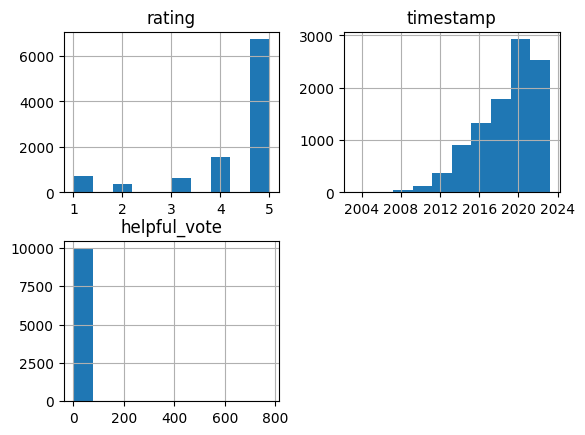

In [63]:
reviews.hist()

In [64]:
items = pd.read_json("../data/2023/meta_Electronics.jsonl", lines=True, nrows=10000) 

In [65]:
items.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Electronics,FS-1051 FATSHARK TELEPORTER V3 HEADSET,3.5,6,[],[Teleporter V3 The “Teleporter V3” kit sets a ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Fat Shark,"[Electronics, Television & Video, Video Glasses]","{'Date First Available': 'August 2, 2014', 'Ma...",B00MCW7G9M,NaN,NaN,NaN
1,All Electronics,Ce-H22B12-S1 4Kx2K Hdmi 4Port,5.0,1,"[UPC: 662774021904, Weight: 0.600 lbs]",[HDMI In - HDMI Out],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],SIIG,"[Electronics, Television & Video, Accessories,...",{'Product Dimensions': '0.83 x 4.17 x 2.05 inc...,B00YT6XQSE,NaN,NaN,NaN
2,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,[WARNING: Please IDENTIFY MODEL NUMBER on the ...,[],19.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'AL 2Sides Video', 'url': 'https://...",Digi-Tatoo,"[Electronics, Computers & Accessories, Laptop ...","{'Brand': 'Digi-Tatoo', 'Color': 'Fresh Marble...",B07SM135LS,NaN,NaN,NaN
3,AMAZON FASHION,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,[☛NotoCity 22mm band is designed for Vivoactiv...,[],9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],NotoCity,"[Electronics, Wearable Technology, Clips, Arm ...","{'Date First Available': 'May 29, 2020', 'Manu...",B089CNGZCW,NaN,NaN,NaN
4,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,"[New Droid X Essentials Combo Pack, Exclusive ...",[all Genuine High Quality Motorola Made Access...,14.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Verizon,"[Electronics, Computers & Accessories, Compute...",{'Product Dimensions': '11.6 x 6.9 x 3.1 inche...,B004E2Z88O,NaN,NaN,NaN


array([[<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'rating_number'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bought_together'}>]], dtype=object)

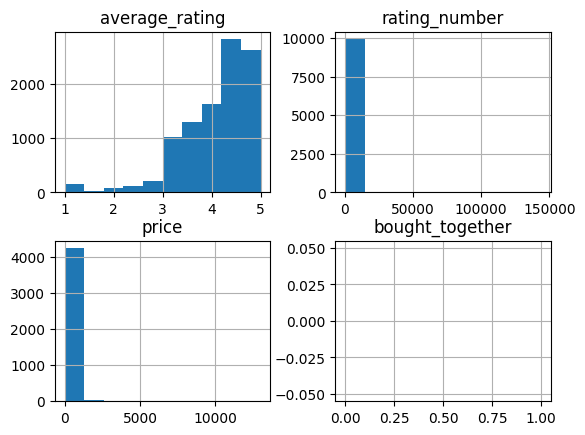

In [66]:
items.hist()

In [67]:
items.iloc[0]

main_category                                        All Electronics
title                         FS-1051 FATSHARK TELEPORTER V3 HEADSET
average_rating                                                   3.5
rating_number                                                      6
features                                                          []
description        [Teleporter V3 The “Teleporter V3” kit sets a ...
price                                                            NaN
images             [{'thumb': 'https://m.media-amazon.com/images/...
videos                                                            []
store                                                      Fat Shark
categories          [Electronics, Television & Video, Video Glasses]
details            {'Date First Available': 'August 2, 2014', 'Ma...
parent_asin                                               B00MCW7G9M
bought_together                                                  NaN
subtitle                          

In [73]:
# Per the dataset documentation: Note: Products with different colors, styles, sizes usually belong to the same parent ID. 
# The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta.
item = reviews.iloc[5].parent_asin
items[items.parent_asin == item]

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author


In [70]:
reviews[reviews.parent_asin == items.iloc[1].parent_asin]

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase


In [74]:
# I'm only loading a fraction of the dataset, so intersections between reviews and items are not guaranteed.

## Model Design 

Managing text-based reviews at this scale could be a challenge, and I'd like to steer clear of LLMs for this effort. We could do an embedding on the review and use that for similarity, but we have pretty rich item data. Perhaps let's ignore the collaborative aspect here and build a shopping interface that: 
- surfaces the most popular items, and encourages you to add items to your shopping cart for a big discount/promo
- based on clicks and cart items, improves the recommendations and surfaces new products

We can use an autoencoder to accept a sparse matrix of users and items, learn to reproduce that matrix, and in so doing support prediction on missing values. However, this matrix is of size users x items, which here is 1.8e7 x 1.6e6 = 28,125,000,000 KB (best-case, higher if stored as np floats) ~= 26 TB !! WTF. 
- In the standard VAE example (https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/standard_vae_deep_dive.ipynb) the clicks are turned into a histogram for each user ... so we have n_user vector of length n_items... then I guess each of these is a training sample. The VAE presumably learns, given a sparse user vector, to predict every rating. This takes the complexity down and gives us a training set we can iterate over. 

Let's avoid any distributional pressure (present in VAE, SVAE, disentangled VAE) and go for a basic autoencoder using the strategy laid out above, i.e.

## Autoencoder Prototype

In [ ]:
import torch 
import pandas as pd 
import torch
from tqdm import tqdm
import os
import math 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb

In [ ]:
class Autoencoder(nn.Module):
    """
    Autoencoder

    NOTE: with cues from https://www.geeksforgeeks.org/deep-learning/implementing-an-autoencoder-in-pytorch/
    """

    def __init__(self, dims=1000):
        """
        Initialize a new object 
        """
        super().__init__()
        
        #TODO: refine this to match our target product embeddings concatenated with user features?
        self.encoder = nn.Sequential(
            nn.Linear(dims, 750),
            nn.Linear(750, 500),
            nn.Linear(500, 250),
            nn.Linear(250, 125),
        )
        self.decoder = nn.Sequential(
            nn.Linear(125, 250),
            nn.Linear(250, 500),
            nn.Linear(500, 750),
            nn.Linear(750, dims),
        )

    def forward(self, x):
        """
        Implement our forward pass 
        """
        h = self.encoder(x) 
        r = self.decoder(h)

        return r

In [ ]:
class DeepCartDataset(torch.utils.data.Dataset): 
    """
    Custom pytorch-compatible dataset. Adapted from 
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None): 

        self.img_labels = pd.read_csv(annotations_file)

        #TODO: implement

    def __len__(self): 
        return len(self.img_labels) 
    
    def __getitem__(self, idx): 
        #TODO: implement
        pass

In [1]:
def get_data_loader(batch_size=5, shuffle=True): 
    """
    Retrieve a pytorch-style dataloader 
    """

    #TODO: implement
    #transform = transforms.Compose([
    #     transforms.ConvertImageDtype(torch.float),
    #     transforms.Normalize(mean=[0.5], std=[0.5])
    #])

    #data = DeepCartDataset(transform=transform)
    #loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    
    #return loader
    pass

In [2]:
def train(loader, model, loss_interval=20, epochs=2, lr=0.01, momentum=0.9):
    """
    Train the model with the provided dataset

    NOTE: this is a similar training loop as we used for our vision model in the 
    the vision project, forward pass
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    train_loss = []

    tqdm.write(f"Starting training run...")    
    # TODO: configure WandB
    # see https://docs.wandb.ai/guides/integrations/pytorch/
    config = {}
    run = wandb.init(config=config) 

    model.train()
    model = model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(loader):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # collect metrics
            running_loss += loss.item()

            if (i % loss_interval) == (loss_interval - 1): 
                train_loss.append(running_loss / loss_interval)
                tqdm.write(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / loss_interval:.3f}")
                running_loss = 0 
    
    tqdm.write("Training complete!") 

    return train_loss 